# Feature selection

In [1]:
%matplotlib inline
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, VarianceThreshold, chi2, RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.datasets import make_classification, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
import category_encoders as ce
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from statsmodels import api as sm

n_cpu = multiprocessing.cpu_count()
n_cpu

16

In [2]:
def read_data(frac=0.02):
    dataframe = pd.read_csv('data/kickstarter.csv', parse_dates=['deadline', 'launched'])
    columns_to_drop_for_cleanup = ["category", "main_category", "country", "currency", "deadline", "launched", "name", "state"]
    
    # create new label by aggregating some of the possible choices
    dataframe = dataframe.assign(outcome=(dataframe['state'] == 'successful').astype(int))
    
    # cycling features handling and feature engineering on dates
    dataframe = dataframe[dataframe.launched != '1970-01-01 01:00:00']
    dataframe = dataframe.assign(
        launched_hour = dataframe.launched.dt.hour,
        launched_day = dataframe.launched.dt.day,
        launched_month = dataframe.launched.dt.month,
        launched_year = dataframe.launched.dt.year
    )
    dataframe['launched_hour_sin'] = np.sin(dataframe.launched_hour * (2. * np.pi/24))
    dataframe['launched_hour_cos'] = np.cos(dataframe.launched_hour * (2. * np.pi/24))
    dataframe['launched_month_sin'] = np.sin(dataframe.launched_month * (2. * np.pi/12))
    dataframe['launched_month_cos'] = np.cos(dataframe.launched_month * (2. * np.pi/12))
    dataframe["week_day"] = dataframe.launched.apply(lambda x: x.day_name())

    # categorical feature encoding
    label_encoding_columns = ["week_day"]
    label_encoder = ce.OrdinalEncoder(cols=label_encoding_columns)
    dataframe = label_encoder.fit_transform(dataframe)
    
    count_target_catboost_encoding_columns = ["category"]
    count_encoder = ce.CountEncoder()
    count_encoded = count_encoder.fit_transform(dataframe[count_target_catboost_encoding_columns])
    dataframe = dataframe.join(count_encoded.add_suffix("_count"))
    target_encoder = ce.TargetEncoder(cols=count_target_catboost_encoding_columns)
    target_encoded = target_encoder.fit_transform(dataframe[count_target_catboost_encoding_columns], dataframe["outcome"]) # normally fit on all and only do transform on the train set
    dataframe = dataframe.join(target_encoded.add_suffix("_target_encoded"))
    catboost_encoder = ce.CatBoostEncoder(cols=count_target_catboost_encoding_columns)
    catboost_encoded = catboost_encoder.fit_transform(dataframe[count_target_catboost_encoding_columns], dataframe["outcome"])
    dataframe = dataframe.join(catboost_encoded.add_suffix("_catboost_encoded"))
    
    one_hot_encoding_columns = ["main_category", "currency", "country"] 
    one_hot_encoder = ce.OneHotEncoder(cols=one_hot_encoding_columns)
    dataframe = one_hot_encoder.fit_transform(dataframe)
    
    # cleanup
    dataframe.drop(columns=columns_to_drop_for_cleanup, axis=1, inplace=True, errors="ignore")
    
    return dataframe.dropna().sample(frac=1).reset_index(drop=True).sample(frac=frac)

## Remove features with low variance

For boolean features, variance can be found with $Var[X] = p(1-p)$ since they are Bernoulli random variables.

By default, removes all zero variance features.

In [3]:
original_df = read_data()
original_df.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
56543,291262891,0,1,0,0,0,0,0,0,0,...,3,2015,0.707107,0.707107,1.000000e+00,6.123234e-17,7,2320,0.393103,0.386063
31353,586273241,1,0,0,0,0,0,0,0,0,...,10,2013,0.707107,0.707107,-8.660254e-01,5.000000e-01,5,9169,0.243538,0.250187
301474,944447181,0,0,1,0,0,0,0,0,0,...,12,2016,0.965926,-0.258819,-2.449294e-16,1.000000e+00,6,15726,0.409004,0.409132
322448,434005442,0,0,1,0,0,0,0,0,0,...,10,2011,-0.707107,0.707107,-8.660254e-01,5.000000e-01,1,15726,0.409004,0.409156
272448,1544683529,0,0,1,0,0,0,0,0,0,...,1,2015,0.866025,0.500000,5.000000e-01,8.660254e-01,2,1092,0.417582,0.376106


In [4]:
original_df.shape

(7497, 72)

In [5]:
feature_cols = original_df.columns.drop('outcome')
feature_cols

Index(['ID', 'main_category_1', 'main_category_2', 'main_category_3',
       'main_category_4', 'main_category_5', 'main_category_6',
       'main_category_7', 'main_category_8', 'main_category_9',
       'main_category_10', 'main_category_11', 'main_category_12',
       'main_category_13', 'main_category_14', 'main_category_15',
       'currency_1', 'currency_2', 'currency_3', 'currency_4', 'currency_5',
       'currency_6', 'currency_7', 'currency_8', 'currency_9', 'currency_10',
       'currency_11', 'currency_12', 'currency_13', 'currency_14', 'goal',
       'pledged', 'backers', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'country_10', 'country_11', 'country_12', 'country_13',
       'country_14', 'country_15', 'country_16', 'country_17', 'country_18',
       'country_19', 'country_20', 'country_21', 'country_22', 'country_23',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'launched

In [6]:
threshold = 0.8 * (1 - 0.8)

selector = VarianceThreshold(threshold=threshold)
df = selector.fit_transform(original_df[feature_cols], original_df['outcome'])

In [7]:
selected_features = pd.DataFrame(selector.inverse_transform(df), index=original_df.index, columns=feature_cols)
selected_features.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
56543,2.912629e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2015.0,0.707107,0.707107,1.000000e+00,6.123234e-17,7.0,2320.0,0.0,0.0
31353,5.862732e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,2013.0,0.707107,0.707107,-8.660254e-01,5.000000e-01,5.0,9169.0,0.0,0.0
301474,9.444472e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,2016.0,0.965926,-0.258819,-2.449294e-16,1.000000e+00,6.0,15726.0,0.0,0.0
322448,4.340054e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,2011.0,-0.707107,0.707107,-8.660254e-01,5.000000e-01,1.0,15726.0,0.0,0.0
272448,1.544684e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2015.0,0.866025,0.500000,5.000000e-01,8.660254e-01,2.0,1092.0,0.0,0.0


In [8]:
selected_columns = selected_features.columns[selected_features.var() != 0]
original_df[selected_columns].head()

,ID,currency_2,goal,pledged,backers,country_2,usd pledged,usd_pledged_real,usd_goal_real,launched_hour,launched_day,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count
56543,291262891,0,80000.0,0.0,0,0,0.0,0.0,63356.3,3,8,3,2015,0.707107,0.707107,1.000000e+00,6.123234e-17,7,2320
31353,586273241,1,20000.0,640.0,15,1,640.0,640.0,20000.0,3,10,10,2013,0.707107,0.707107,-8.660254e-01,5.000000e-01,5,9169
301474,944447181,1,750.0,1199.0,32,1,647.0,1199.0,750.0,7,28,12,2016,0.965926,-0.258819,-2.449294e-16,1.000000e+00,6,15726
322448,434005442,1,20000.0,20.0,1,1,20.0,20.0,20000.0,21,25,10,2011,-0.707107,0.707107,-8.660254e-01,5.000000e-01,1,15726
272448,1544683529,1,2000.0,1302.0,11,1,1302.0,1302.0,2000.0,4,17,1,2015,0.866025,0.500000,5.000000e-01,8.660254e-01,2,1092


## Univariate Feature Selection

For each feature, measure how strongly the target depends on the feature using a statistical test like $X^2$ or ANOVA.

This is done one feature at a time.

In scikit learn, feature_selection.SelectKBest returns the K best features given some scoring function. We just need to decide the number of features we want to keep.

**SelectKBest should not be done on the validation and test set otherwise data leakage.**

* For regression: f_regression, mutual_info_regression
* For classification: chi2, f_classif, mutual_info_classif

mutual_info_regression, mutual_info_classif, chi2 can handle sparse data without making it dense.

In [9]:
original_df = read_data()
original_df.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
337895,165002982,0,1,0,0,0,0,0,0,0,...,3,2014,1.224647e-16,-1.000000,1.000000,6.123234e-17,1,12357,0.540018,0.547758
334012,2006911570,0,0,1,0,0,0,0,0,0,...,3,2014,-8.660254e-01,0.500000,1.000000,6.123234e-17,3,2170,0.322581,0.320497
273314,901655251,0,1,0,0,0,0,0,0,0,...,7,2015,7.071068e-01,-0.707107,-0.500000,-8.660254e-01,2,16139,0.367061,0.366670
240537,1274145394,0,1,0,0,0,0,0,0,0,...,10,2016,0.000000e+00,1.000000,-0.866025,5.000000e-01,3,16139,0.367061,0.361968
35830,2059721326,0,0,0,0,0,0,0,0,1,...,1,2016,-7.071068e-01,0.707107,0.500000,8.660254e-01,3,3165,0.339021,0.321717


In [10]:
original_df.shape

(7497, 72)

In [11]:
original_df.describe()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
count,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,...,7497.000000,7497.000000,7497.000000,7497.000000,7.497000e+03,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000
mean,1.074332e+09,0.104442,0.163265,0.126717,0.066026,0.080966,0.022809,0.100440,0.027611,0.063492,...,6.453115,2014.226491,-0.221956,0.233276,-7.981138e-03,-5.306165e-02,3.722956,7490.359344,0.355195,0.356742
std,6.182693e+08,0.305853,0.369632,0.332678,0.248345,0.272801,0.149305,0.300606,0.163867,0.243862,...,3.325377,1.936265,0.696874,0.640940,7.095808e-01,7.026727e-01,1.896803,5946.151768,0.141405,0.142286
min,2.065170e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2009.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,1.000000,27.000000,0.059574,0.013103
25%,5.365923e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,2013.000000,-0.866025,-0.258819,-8.660254e-01,-8.660254e-01,2.000000,2613.000000,0.255787,0.254019
50%,1.083293e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,2014.000000,-0.500000,0.258819,1.224647e-16,-1.836970e-16,4.000000,6345.000000,0.348816,0.350071
75%,1.600476e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,2016.000000,0.500000,0.866025,5.000000e-01,5.000000e-01,5.000000,11493.000000,0.433612,0.436469
max,2.146831e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,12.000000,2018.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,7.000000,22314.000000,0.771429,0.739229


In [12]:
feature_cols = original_df.columns.drop('outcome')
feature_cols

Index(['ID', 'main_category_1', 'main_category_2', 'main_category_3',
       'main_category_4', 'main_category_5', 'main_category_6',
       'main_category_7', 'main_category_8', 'main_category_9',
       'main_category_10', 'main_category_11', 'main_category_12',
       'main_category_13', 'main_category_14', 'main_category_15',
       'currency_1', 'currency_2', 'currency_3', 'currency_4', 'currency_5',
       'currency_6', 'currency_7', 'currency_8', 'currency_9', 'currency_10',
       'currency_11', 'currency_12', 'currency_13', 'currency_14', 'goal',
       'pledged', 'backers', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'country_10', 'country_11', 'country_12', 'country_13',
       'country_14', 'country_15', 'country_16', 'country_17', 'country_18',
       'country_19', 'country_20', 'country_21', 'country_22', 'country_23',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'launched

In [13]:
selector = SelectKBest(f_classif, k=5)
df = selector.fit_transform(original_df[feature_cols], original_df['outcome'])

/home/gillouche/workspace/exploratory-data-analysis/venv-exploratory-data-analysis/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [43] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/gillouche/workspace/exploratory-data-analysis/venv-exploratory-data-analysis/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [14]:
selected_features = pd.DataFrame(selector.inverse_transform(df), index=original_df.index, columns=feature_cols)
selected_features.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
337895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.540018,0.547758
334012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322581,0.320497
273314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.367061,0.366670
240537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.367061,0.361968
35830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.339021,0.321717


In [15]:
selected_columns = selected_features.columns[selected_features.var() != 0]
original_df[selected_columns].head()

,main_category_13,backers,usd pledged,category_target_encoded,category_catboost_encoded
337895,0,20,840.62,0.540018,0.547758
334012,0,3,151.00,0.322581,0.320497
273314,0,0,0.00,0.367061,0.366670
240537,0,244,2625.00,0.367061,0.361968
35830,0,3,30.46,0.339021,0.321717


## Regularizations

L1 Regularization (Lasso) penalizes the absolute magnitude of the coefficients. As the strength of regularization is increased, features which are less important for predicting the target are set to 0 (also check LassoCV for cross validation and lasso regularization).

We can perform feature selection by adjusting the regularization parameter. We choose the parameter by finding the best performance on a hold-out set, or decide ahead of time how many features to keep.

C is the inverse of regularization strength, must be a positive float. smaller values specify strong regularization.

Not all solvers support L1 regularization.

* newton-cg: supports multi class problem, handles L2 and no penalty
* lbfgs: supports multi class problem, handles L2 and no penalty
* liblinear: good choice for small dataset, does not support multi class problem (only one versus rest), handles L1 penalty
* sag: good for large dataset, supports multi class problem, handles L2 and no penalty
* saga: good for large dataset, supports multi class problem, handles L1, L2, elasticnetand no penalty

L2 regularization (Ridge) penalizes the coefficients but don't make them reach 0 so this doesn't act as a feature selection method (also check RidgeCV for cross validation and ridge regularization).

In [16]:
original_df = read_data()
original_df.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
7145,201753240,1,0,0,0,0,0,0,0,0,...,5,2011,-1.000000,-1.836970e-16,5.000000e-01,-8.660254e-01,4,8318,0.268093,0.259764
159126,149168863,0,0,0,0,0,0,1,0,0,...,2,2015,0.258819,-9.659258e-01,8.660254e-01,5.000000e-01,5,14180,0.554725,0.555042
209258,559978246,0,1,0,0,0,0,0,0,0,...,11,2013,0.500000,8.660254e-01,-5.000000e-01,8.660254e-01,4,10106,0.303780,0.301232
38570,1105097948,0,0,0,0,0,1,0,0,0,...,6,2016,0.866025,5.000000e-01,1.224647e-16,-1.000000e+00,4,429,0.128205,0.181407
261013,943638596,0,0,1,0,0,0,0,0,0,...,3,2011,-0.965926,-2.588190e-01,1.000000e+00,6.123234e-17,1,15726,0.409004,0.409153


In [17]:
original_df.describe()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
count,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,...,7497.000000,7497.000000,7497.000000,7497.000000,7.497000e+03,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000
mean,1.077092e+09,0.107510,0.167000,0.132853,0.065893,0.076564,0.025210,0.093771,0.030679,0.064026,...,6.405896,2014.222356,-0.233910,0.235323,-6.314148e-03,-5.977373e-02,3.766440,7436.918501,0.353262,0.354481
std,6.240134e+08,0.309781,0.373001,0.339439,0.248112,0.265916,0.156773,0.291529,0.172458,0.244815,...,3.309737,1.929256,0.688193,0.645305,7.143288e-01,6.973195e-01,1.912648,5901.004801,0.141552,0.142504
min,5.683300e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2009.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,1.000000,27.000000,0.059574,0.032161
25%,5.254596e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,2013.000000,-0.866025,-0.258819,-8.660254e-01,-8.660254e-01,2.000000,2613.000000,0.249142,0.253746
50%,1.086566e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,2014.000000,-0.500000,0.258819,1.224647e-16,-1.836970e-16,4.000000,6017.000000,0.347543,0.348312
75%,1.622506e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,2016.000000,0.258819,0.866025,8.660254e-01,5.000000e-01,5.000000,11493.000000,0.432787,0.432731
max,2.146954e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,12.000000,2018.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,7.000000,22314.000000,0.771429,0.779481


In [18]:
original_df.shape

(7497, 72)

In [19]:
feature_cols = original_df.columns.drop('outcome')
feature_cols

Index(['ID', 'main_category_1', 'main_category_2', 'main_category_3',
       'main_category_4', 'main_category_5', 'main_category_6',
       'main_category_7', 'main_category_8', 'main_category_9',
       'main_category_10', 'main_category_11', 'main_category_12',
       'main_category_13', 'main_category_14', 'main_category_15',
       'currency_1', 'currency_2', 'currency_3', 'currency_4', 'currency_5',
       'currency_6', 'currency_7', 'currency_8', 'currency_9', 'currency_10',
       'currency_11', 'currency_12', 'currency_13', 'currency_14', 'goal',
       'pledged', 'backers', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'country_10', 'country_11', 'country_12', 'country_13',
       'country_14', 'country_15', 'country_16', 'country_17', 'country_18',
       'country_19', 'country_20', 'country_21', 'country_22', 'country_23',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'launched

In [20]:
X_train, X_test, y_train, y_test = train_test_split(original_df[feature_cols], original_df['outcome'], test_size=0.25, random_state=42)
print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (5622, 71)
y train shape: (5622,)
X test shape: (1875, 71)
y test shape: (1875,)


In [21]:
standard_scaler = StandardScaler()

X_train_std = standard_scaler.fit_transform(X_train)
X_test_std = standard_scaler.transform(X_test)

In [22]:
C = [10, 1, .1, .001, .0001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='saga', max_iter=10_000, n_jobs=n_cpu)
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print('')

C: 10
Coefficient of each feature: [[-4.35747293e-10 -1.71357801e-13 -5.80659168e-14  2.69773609e-13
  -1.50047256e-13 -5.49465165e-14 -6.60156409e-14 -5.28331557e-14
   1.02901786e-13 -2.00499563e-13  9.56852617e-14 -2.00374311e-14
  -4.88349103e-14 -3.14213439e-13  4.14684872e-14 -5.21177505e-14
  -8.52305803e-15 -3.46474996e-13 -7.87997468e-14 -3.34507959e-14
  -1.34387951e-14 -1.51187015e-13 -1.73040467e-14 -1.29043326e-14
  -1.36209010e-14 -4.44029964e-15  1.98101026e-15 -4.35948435e-15
   5.08917241e-15 -6.29240248e-16 -1.41230980e-07  8.88917416e-08
   9.45262648e-10 -8.52305803e-15 -3.46474996e-13 -7.87997468e-14
  -3.34507959e-14 -1.34387951e-14 -4.78702079e-14 -2.90376037e-14
  -4.15837971e-15 -1.73040467e-14 -2.13898066e-14  0.00000000e+00
  -1.29043326e-14  2.09435343e-15 -3.42903465e-14 -1.36209010e-14
  -4.44029964e-15 -9.23819574e-15  1.98101026e-15 -5.49978950e-15
  -4.35948435e-15  0.00000000e+00  5.08917241e-15 -6.29240248e-16
   6.28635007e-08  7.80978985e-08 -1.3001

## Recursive Feature Elimination for feature selection

two important configuration options

* number of features to keep
* the algorithm used to help choose features

### For classification

In [23]:
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
print(X.shape, y.shape)

(1000, 10) (1000,)


In [24]:
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

In [25]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.884 (0.035)


In [26]:
pipeline.fit(X, y)
data = [[2.56999479,-0.13019997,3.16075093,-4.35936352,-1.61271951,-1.39352057,-2.48924933,-1.93094078,3.26130366,2.05692145]]
y_hat = pipeline.predict(data)
print('Predicted Class: %d' % (y_hat))

Predicted Class: 1


In [27]:
rfe.support_

array([False, False,  True,  True,  True, False,  True, False,  True,
       False])

In [28]:
rfe.ranking_

array([4, 6, 1, 1, 1, 5, 1, 3, 1, 2])

### For regression

In [29]:
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
print(X.shape, y.shape)

(1000, 10) (1000,)


In [30]:
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

In [31]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -26.779 (2.823)


In [32]:
pipeline.fit(X, y)
data = [[-2.02220122,0.31563495,0.82797464,-0.30620401,0.16003707,-1.44411381,0.87616892,-0.50446586,0.23009474,0.76201118]]
yhat = pipeline.predict(data)
print('Predicted: %.3f' % (yhat))

Predicted: -84.288


In [33]:
rfe.support_

array([False,  True,  True, False,  True,  True,  True, False, False,
       False])

In [34]:
rfe.ranking_

array([4, 1, 1, 5, 1, 1, 1, 3, 2, 6])

### RFE Hyperparameters

In [35]:
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
	return X, y
 
def get_models():
	models = dict()
	for i in range(2, 10):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [36]:
X, y = get_dataset()
models = get_models()
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>2 0.720 (0.044)
>3 0.819 (0.035)
>4 0.876 (0.034)
>5 0.890 (0.036)
>6 0.886 (0.033)
>7 0.886 (0.027)
>8 0.886 (0.027)
>9 0.882 (0.028)


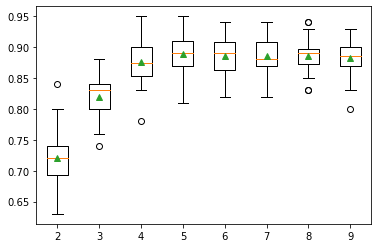

In [37]:
plt.boxplot(results, labels=names, showmeans=True);

## RFE internal algorithm

In [38]:
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
    return X, y
 
def get_models():
    models = dict()

    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['logi_reg'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['perceptron'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['dec_tree'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['rand_fo'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['grad_boos'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=n_cpu)
    return scores


In [39]:
X, y = get_dataset()
models = get_models()

results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))


>logi_reg 0.895 (0.030)
>perceptron 0.846 (0.040)
>dec_tree 0.887 (0.034)
>rand_fo 0.851 (0.033)
>grad_boos 0.886 (0.033)


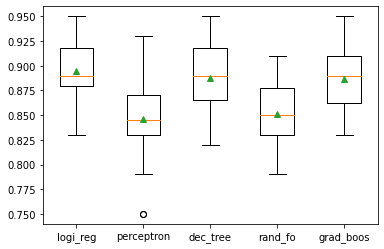

In [40]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Ordinary Least Squares

R squared is a value between 0 and 1, the closer to 1, the better the model is at explained data variance

Adjusted R squared penalizes the complexity of the model by punishing useless variables added to the model.

In [41]:
df = sns.load_dataset('iris')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [42]:
X = df["petal_length"]
# add a constant (intercept) to show the difference R²
X = np.vander(X, 2)
y = df["petal_width"]
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            petal_width   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     1882.
Date:                Thu, 04 Jun 2020   Prob (F-statistic):           4.68e-86
Time:                        16:25:18   Log-Likelihood:                 24.796
No. Observations:                 150   AIC:                            -45.59
Df Residuals:                     148   BIC:                            -39.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4158      0.010     43.387      0.000       0.397       0.435
const         -0.3631      0.040     -9.131      0.000      -0.442      -0.285
==============================================================================
Omnibus:                        5.765   Durbin-Watson:                   1.455
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.555
Skew:                           0.359   Prob(JB):                       0.0622
Kurtosis:                       3.611   Cond. No.                         10.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# remove the constant
X = df[["petal_length"]]
print(X.head())
y = df["petal_width"]
model = sm.OLS(y, X)
result = model.fit()
result.summary()

   petal_length
0           1.4
1           1.4
2           1.3
3           1.5
4           1.4


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            petal_width   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              4417.
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                   1.22e-112
Time:                        16:25:18   Log-Likelihood:                         -8.7179
No. Observations:                 150   AIC:                                      19.44
Df Residuals:                     149   BIC:                                      22.45
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
petal_length     0.3365      0.005     66.463      0.000       0.327       0.347
==============================================================================
Omnibus:                       19.720   Durbin-Watson:                   0.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.498
Skew:                           0.957   Prob(JB):                     7.90e-06
Kurtosis:                       3.311   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""